# Imports

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
from deap import creator, base, tools, algorithms

# Dataset

In [3]:
# Load dataset 
# header=None because the first row is not a header
data = pd.read_excel('Project3_DistancesMatrix.xlsx', header=None) 

# Verified if the dataset has missing values
print(data.isnull().sum().sum())

# Used to create the distances.csv file for testing, not necessary for solving the problem
"""  
# from np.array() to dataframe pandas
distances123 = pd.DataFrame(distances)

# distances to csv
distances123.to_csv('distances.csv', index=False, header=False)

# Load dataset with float values to pandas dataframe
distances_test = pd.read_csv('distances.csv', header=None)

# pd to numpy array
distances_test = distances_test.to_numpy() 
"""

0


"  \n# from np.array() to dataframe pandas\ndistances123 = pd.DataFrame(distances)\n\n# distances to csv\ndistances123.to_csv('distances.csv', index=False, header=False)\n\n# Load dataset with float values to pandas dataframe\ndistances_test = pd.read_csv('distances.csv', header=None)\n\n# pd to numpy array\ndistances_test = distances_test.to_numpy() \n"

# Evolutionary Algorithm 

In [6]:
# Exclude first row and column, beacuse they are labels
### ATENTION: In the test, we will not receive like this
distances = data.values[1:, 1:]  

# 100 ecopoints, in this case
number_of_ecopoints = len(distances) - 1


def evalTSP(individual: list)-> tuple: 
    """
    Fitness of an individual. The fitness is the total distance of the route.

    Args:
        individual (list): Individual to evaluate

    Returns:
        tuple: Tuple with a float value of Fitness of the individual
    """    

    total_distance = sum(distances[individual[i-1] + 1][individual[i] + 1] for i in range(1, len(individual)))
    total_distance += distances[0][individual[0] + 1]
    total_distance += distances[individual[-1] + 1][0]
    
    # Return a tuple with a single value because it's a requisite of DEAP
    return (total_distance,)  

def nearest_neighbor_tour(distances: list) -> list:
    """
    Nearest neighbor tour algorithm. It's used to create a initial population. 

    Args:
        distances (_type_): distances matrix.

    Returns:
        tour: List with the nearest neighbor tour.
    """    
    
    num_cities = len(distances)
    start_city = 0
    tour = [start_city]
    unvisited_cities = set(range(1, num_cities))
    while unvisited_cities:
        next_city = min(unvisited_cities, key=lambda city: distances[tour[-1]][city])
        unvisited_cities.remove(next_city)
        tour.append(next_city)
    return tour

#### Custom functions

In [9]:
def custom_mutShuffleIndexes(individual, indpb):
    size = len(individual)
    for i in range(1, size-1):
        if random.random() < indpb:
            swap_indx = random.randint(1, size - 2)
            individual[i], individual[swap_indx] = (
                individual[swap_indx],
                individual[i],
            )
    return individual,

def custom_cxOrdered(ind1, ind2):
    size = min(len(ind1), len(ind2))
    a, b = random.sample(range(size), 2)
    if a > b:
        a, b = b, a

    holes1, holes2 = [True]*size, [True]*size
    for i in range(size):
        if i < a or i > b:
            holes1[ind2[i]-1] = False
            holes2[ind1[i]-1] = False

    # We must keep the original values somewhere before scrambling everything
    temp1, temp2 = ind1, ind2
    k1 , k2 = b + 1, b + 1
    for i in range(size):
        if not holes1[temp1[(i + b + 1) % size]-1]:
            ind1[k1 % size] = temp1[(i + b + 1) % size]
            k1 += 1
        if not holes2[temp2[(i + b + 1) % size]-1]:
            ind2[k2 % size] = temp2[(i + b + 1) % size]
            k2 += 1
    # Swap the content between a and b (included)
    for i in range(a, b + 1):
        ind1[i], ind2[i] = ind2[i], ind1[i]
    ind1[0] = ind1[-1] = 0
    ind2[0] = ind2[-1] = 0
    return ind1, ind2

#### Genetic algorithm parameters

In [11]:
# FitnessMin is a class inherited from base.Fitness and it has weights and values attributes
# Individual is a list of integers (ecopoints)
# weights = (-1.0,) because we want to minimize the total distance, (1.0) if we want to maximize
# Toolbox is a container for the tools that will be used to manipulate the individuals

# Register genetic operators
# mate: cxOrdered - order crossover
# mutate: mutShuffleIndexes - shuffle mutation
# select: selTournament - tournament selection


creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", list, fitness=creator.FitnessMin)

toolbox = base.Toolbox()
"""
#toolbox.register("indices", nearest_neighbor_tour, distances)
toolbox.register("indices", np.random.permutation, len(distances))
toolbox.register("individual", tools.initIterate, creator.Individual, toolbox.indices)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

toolbox.register("mate", tools.cxTwoPoint)
toolbox.register("mutate", tools.mutShuffleIndexes, indpb=0.00)
toolbox.register("select", tools.selTournament, tournsize=3)
toolbox.register("evaluate", evalTSP)

"""

toolbox.register("indices", np.random.permutation, range(number_of_ecopoints)) 
toolbox.register("individual", tools.initIterate, creator.Individual, toolbox.indices)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

# Register genetic operators
# mate: cxOrdered - order crossover
# mutate: mutShuffleIndexes - shuffle mutation
# select: selTournament - tournament selection

toolbox.register("mate", tools.cxOrdered) # cxOrdered - order crossover CANNOT BE USED
toolbox.register("mutate", tools.mutShuffleIndexes, indpb=0.05)
#toolbox.register("mutate", customMutShuffleIndexes, indpb=0.10)
#toolbox.register("mate", customCxOrdered)
toolbox.register("select", tools.selTournament, tournsize=3)
toolbox.register("evaluate", evalTSP)

### Try 0

In [ ]:
import time

# Population
pop = toolbox.population(n=50000)

# Hall of fame of 1 best individual
hof = tools.HallOfFame(1)

stats = tools.Statistics(lambda ind: ind.fitness.values)
stats.register("avg", np.mean)
stats.register("min", np.min)
stats.register("max", np.max)

print("Start of evolution")

start_time = time.time()
timeout = 20 * 60  # 20 minutes in seconds

# Run the evolution
gen = 0
while time.time() - start_time < timeout:
    gen += 1
    # Select and clone the next generation individuals
    offspring = map(toolbox.clone, toolbox.select(pop, len(pop)))
    
    # Apply crossover and mutation on the offspring
    offspring = algorithms.varAnd(offspring, toolbox, cxpb=0.5, mutpb=0.2)

    # Evaluate the individuals with an invalid fitness
    invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
    fitnesses = map(toolbox.evaluate, invalid_ind)
    for ind, fit in zip(invalid_ind, fitnesses):
        ind.fitness.values = fit
    
    # Replace the current population by the offspring
    pop[:] = offspring

    # Update the hall of fame with the generated individuals
    hof.update(pop)

    # Record the stats of the current generation
    record = stats.compile(pop)
    print(f"Generation {gen}: {record}")

# Best individual
print(f"Best individual is: {hof[0]}, {len(hof[0])} \nwith fitness: {hof[0].fitness}")

### Try limit of time

In [54]:
import time

# Population
pop = toolbox.population(n=1000)

# Hall of fame of 1 best individual
hof = tools.HallOfFame(1)

stats = tools.Statistics(lambda ind: ind.fitness.values)
stats.register("avg", np.mean)
stats.register("min", np.min)
stats.register("max", np.max)

print("Start of evolution")

start_time = time.time()
timeout = 19 * 60  # minutes x seconds

# Run the evolution
gen = 0
while time.time() - start_time < timeout and gen < 10000:
    gen += 1
    # Select and clone the next generation individuals
    offspring = map(toolbox.clone, toolbox.select(pop, len(pop)))
    
    # Apply crossover and mutation on the offspring
    offspring = algorithms.varAnd(offspring, toolbox, cxpb=0.5, mutpb=0.05)

    # Evaluate the individuals with an invalid fitness
    invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
    fitnesses = map(toolbox.evaluate, invalid_ind)
    for ind, fit in zip(invalid_ind, fitnesses):
        ind.fitness.values = fit
    
    # Replace the current population by the offspring
    pop[:] = offspring

    # Update the hall of fame with the generated individuals
    hof.update(pop)

    # Record the stats of the current generation
    record = stats.compile(pop)
    print(f"Generation {gen}: {record}")

# Best individual
print(f"Best individual is: {hof[0]}, {len(hof[0])} \nwith fitness: {hof[0].fitness}")

Start of evolution
Generation 1: {'avg': 335.3241, 'min': 289.5999999999999, 'max': 395.29999999999995}
Generation 2: {'avg': 321.74719999999996, 'min': 276.80000000000007, 'max': 371.0999999999999}
Generation 3: {'avg': 312.4516, 'min': 268.5000000000001, 'max': 354.10000000000014}
Generation 4: {'avg': 303.8937, 'min': 254.3, 'max': 346.89999999999986}
Generation 5: {'avg': 296.8671, 'min': 254.3, 'max': 347.40000000000003}
Generation 6: {'avg': 290.25219999999996, 'min': 250.60000000000002, 'max': 334.09999999999997}
Generation 7: {'avg': 284.76279999999997, 'min': 249.69999999999996, 'max': 339.80000000000007}
Generation 8: {'avg': 279.288, 'min': 243.20000000000002, 'max': 332.40000000000015}
Generation 9: {'avg': 273.522, 'min': 241.49999999999991, 'max': 320.4000000000001}
Generation 10: {'avg': 269.038, 'min': 237.7, 'max': 320.80000000000007}
Generation 11: {'avg': 264.1816, 'min': 235.4, 'max': 313.7999999999999}
Generation 12: {'avg': 260.88689999999997, 'min': 212.200000000

### CARIA

In [18]:
import time
import matplotlib.pyplot as plt

# seed for reproducibility
random.seed(169)

n_populations = 1000 
n_generations = 10 * n_populations 
prob_mutation = 0.05 # 0.01, 0.05, 0.1, 0.2
prob_crossover = 0.8 # 0.5, 0.6, 0.7, 0.8
convergence_generations = n_generations//10  # Number of generations over which to check for convergence
convergence_threshold = 0.0001  # The relative change in best fitness that signifies convergence

# Population
pop = toolbox.population(n=n_populations)

# Hall of fame of 1 best individual
hof = tools.HallOfFame(1)

# Lists to store the fitness evolution
best_fitness_evolution = []
avg_fitness_evolution = []
min_fitness_evolution = []
max_fitness_evolution = []

stats = tools.Statistics(lambda ind: ind.fitness.values)
stats.register("avg", np.mean)
stats.register("min", np.min)
stats.register("max", np.max)

print("Start of evolution")

start_time = time.time()
timeout = 19 * 60  # minutes x seconds

# Run the evolution
gen = 0
converged = False
while time.time() - start_time < timeout and gen < n_generations and not converged:
    gen += 1
    # Select and clone the next generation individuals
    offspring = map(toolbox.clone, toolbox.select(pop, len(pop)))
    
    # Apply crossover and mutation on the offspring
    offspring = algorithms.varAnd(offspring, toolbox, cxpb=prob_crossover, mutpb=prob_mutation)

    # Evaluate the individuals with an invalid fitness
    invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
    fitnesses = map(toolbox.evaluate, invalid_ind)
    for ind, fit in zip(invalid_ind, fitnesses):
        ind.fitness.values = fit
    
    # Replace the current population by the offspring
    pop[:] = offspring

    # Update the hall of fame with the generated individuals
    hof.update(pop)

    # Record the stats of the current generation
    record = stats.compile(pop)
    print(f"Generation {gen}: {record}")

    # Record the best, avg, min and max fitness from this generation to the lists
    best_fitness_evolution.append(hof[0].fitness.values[0])
    avg_fitness_evolution.append(record["avg"])
    min_fitness_evolution.append(record["min"])
    max_fitness_evolution.append(record["max"])

    # Check for convergence: if the best fitness has not improved significantly for a certain number of generations
    if gen >= convergence_generations:
        relative_change = (best_fitness_evolution[-convergence_generations] - best_fitness_evolution[-1]) / best_fitness_evolution[-convergence_generations]
        if abs(relative_change) < convergence_threshold:
            print("Convergence reached")
            converged = True

# Best individual
print(f"Best individual is: {hof[0]}, {len(hof[0])} \nwith fitness: {hof[0].fitness}")


Start of evolution
Generation 1: {'avg': 334.7218, 'min': 275.49999999999994, 'max': 394.4}
Generation 2: {'avg': 317.15889999999996, 'min': 266.6, 'max': 370.3999999999999}
Generation 3: {'avg': 304.72709999999995, 'min': 258.40000000000003, 'max': 351.59999999999997}
Generation 4: {'avg': 296.536, 'min': 251.80000000000007, 'max': 347.0}
Generation 5: {'avg': 287.50809999999996, 'min': 246.30000000000004, 'max': 335.8999999999998}
Generation 6: {'avg': 279.91020000000003, 'min': 236.50000000000006, 'max': 333.00000000000006}
Generation 7: {'avg': 272.95090000000005, 'min': 236.50000000000006, 'max': 328.9999999999999}
Generation 8: {'avg': 268.3066, 'min': 233.5, 'max': 323.69999999999993}
Generation 9: {'avg': 264.1335, 'min': 231.19999999999996, 'max': 316.8}
Generation 10: {'avg': 260.4771, 'min': 226.00000000000009, 'max': 325.20000000000016}
Generation 11: {'avg': 257.8532, 'min': 220.89999999999995, 'max': 322.2}
Generation 12: {'avg': 252.22440000000003, 'min': 211.70000000000

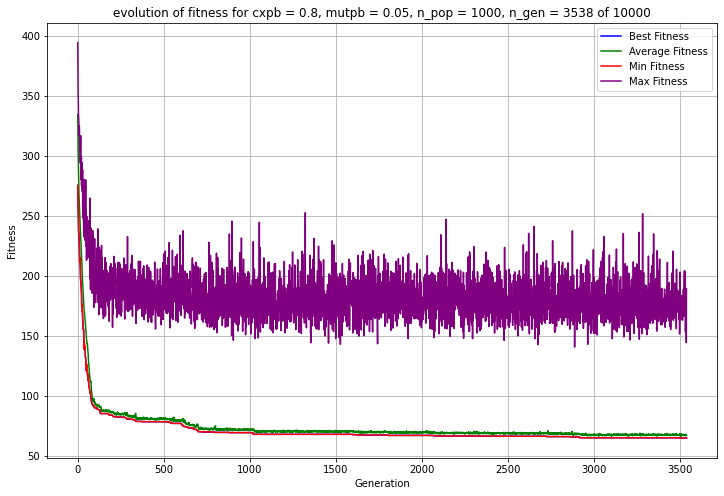

In [20]:
# Plot the evolution of the fitness
def plot_evolution(which_stats,cxpb, mutpb, n_pop, n_gen):
    plt.figure(figsize=(12, 8))
    if "fitness" in which_stats:
        plt.plot(best_fitness_evolution, label='Best Fitness', color='blue')
    if "avg" in which_stats:
        plt.plot(avg_fitness_evolution, label='Average Fitness', color='green')
    if "min" in which_stats:
        plt.plot(min_fitness_evolution, label='Min Fitness', color='red')
    if "max" in which_stats:
        plt.plot(max_fitness_evolution, label='Max Fitness', color='purple')
    plt.xlabel("Generation")
    plt.ylabel("Fitness")
    plt.title(f"evolution of fitness for cxpb = {cxpb}, mutpb = {mutpb}, n_pop = {n_pop}, n_gen = {n_gen} of {n_generations}")
    plt.legend()
    plt.grid(True)
    plt.show()



plot_evolution(["fitness", "avg", "min", "max"], prob_crossover, prob_mutation, n_populations, gen)

#plot_evolution(["fitness", "avg", "min"])


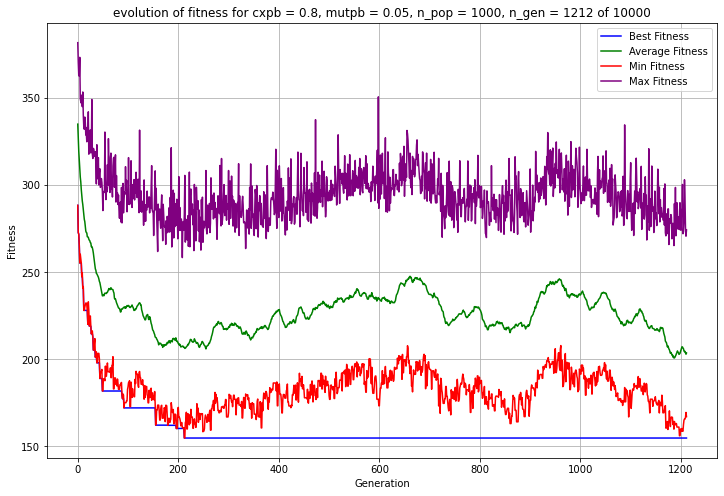

In [163]:
plot_evolution(["fitness", "avg", "min", "max"], prob_crossover, prob_mutation, n_populations, gen)

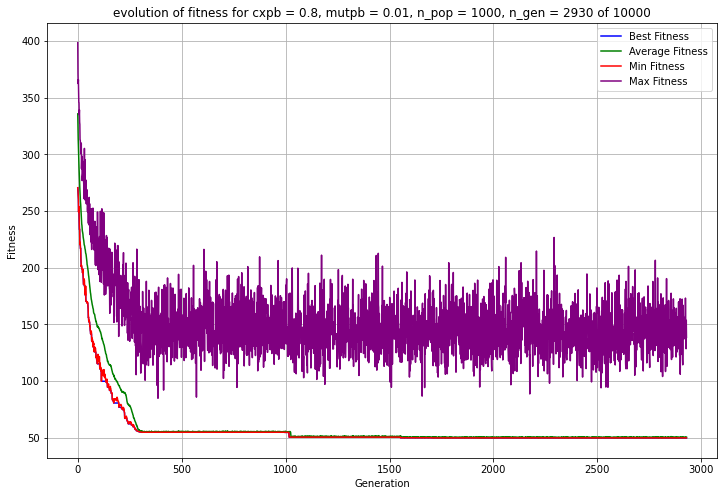

In [159]:
plot_evolution(["fitness", "avg", "min", "max"], prob_crossover, prob_mutation, n_populations, gen)

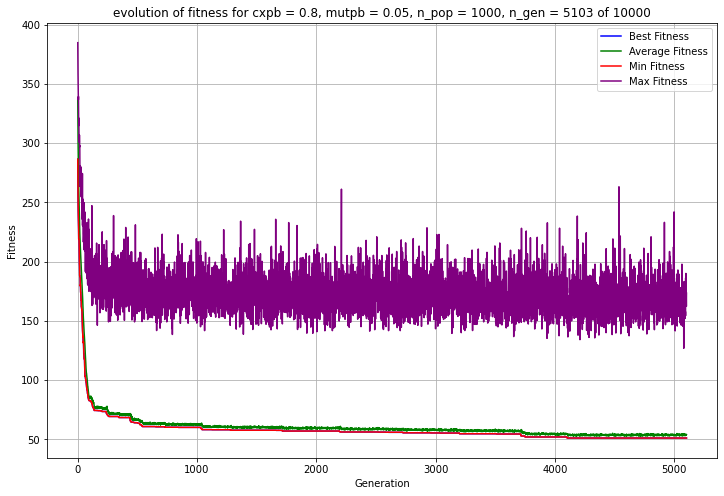

In [166]:
plot_evolution(["fitness", "avg", "min", "max"], prob_crossover, prob_mutation, n_populations, gen)

In [21]:
#0.05 mut, 3 tour, 0.8 cross
#fitness: (64.99999999999999,)
best_1 = [0, 63, 81, 57, 53, 39, 30, 55, 87, 31, 82, 92, 85, 93, 94, 4, 27, 76, 75, 25, 9, 14, 60, 48, 18, 10, 45, 0, 44, 56, 8, 72, 74, 61, 79, 15, 35, 69, 7, 23, 73, 3, 51, 95, 22, 1, 70, 12, 49, 90, 41, 37, 36, 34, 21, 50, 38, 98, 96, 77, 91, 52, 86, 11, 29, 59, 16, 6, 89, 83, 5, 71, 26, 78, 54, 20, 80, 43, 84, 68, 32, 17, 33, 88, 42, 64, 28, 46, 47, 97, 24, 67, 2, 66, 58, 13, 40, 62, 19, 65, 0]

#0.01 mut, 3 tour, 0.8 cross
#fitness: (43.90000000000001,)
best_2 = [0, 5, 2, 47, 46, 10, 60, 45, 6, 89, 88, 33, 42, 16, 11, 86, 29, 59, 0, 44, 56, 57, 8, 53, 72, 52, 74, 39, 94, 93, 85, 82, 92, 4, 37, 36, 41, 34, 70, 12, 55, 77, 96, 49, 7, 30, 35, 15, 51, 95, 73, 3, 87, 31, 50, 21, 38, 98, 90, 69, 23, 79, 20, 91, 61, 81, 63, 17, 80, 1, 22, 54, 32, 84, 43, 68, 27, 78, 76, 26, 75, 71, 83, 25, 14, 48, 28, 9, 64, 18, 97, 67, 24, 66, 58, 62, 40, 13, 65, 19, 0]

#0.05 mut, 5 tour, 0.8 cross
#fitness: (53.72)
best_3 = [0, 75, 95, 51, 22, 68, 84, 73, 12, 70, 69, 7, 23, 30, 90, 35, 49, 98, 50, 21, 31, 87, 38, 3, 96, 77, 55, 15, 1, 80, 81, 11, 29, 86, 74, 37, 41, 36, 34, 17, 63, 42, 33, 88, 89, 25, 46, 9, 60, 48, 18, 10, 45, 6, 16, 0, 59, 44, 56, 57, 53, 8, 52, 61, 91, 39, 4, 82, 92, 85, 93, 94, 72, 79, 20, 54, 27, 76, 26, 78, 32, 43, 71, 83, 62, 65, 19, 40, 13, 58, 66, 2, 67, 97, 24, 47, 64, 28, 14, 5, 0]


### best 4h
# Best individual is: [27, 32, 68, 84, 43, 80, 61, 91, 79, 20, 54, 22, 51, 95, 73, 3, 96, 98, 50, 38, 87, 31, 21, 55, 77, 70, 12, 49, 7, 35, 90, 30, 23, 69, 15, 1, 34, 36, 37, 41, 94, 93, 85, 82, 92, 4, 39, 74, 52, 72, 53, 8, 86, 57, 56, 44, 11, 59, 29, 0, 16, 6, 45, 25, 18, 10, 46, 14, 28, 64, 60, 9, 48, 47, 2, 67, 97, 24, 5, 40, 19, 62, 13, 58, 66, 83, 89, 88, 33, 42, 81, 78, 26, 76, 17, 63, 75, 71, 65], 99 
# with fitness: (40.800000000000004,)

### Try 2

In [49]:
import time

# Define your stopping criteria
max_time = 19 * 60  # 20 minutes in seconds
max_stable_gens = 7
convergence_threshold = 2000

# Initialize the population and start the evolution
pop = toolbox.population(n=50000)
hof = tools.HallOfFame(1)
stats = tools.Statistics(lambda ind: ind.fitness.values)
stats.register("avg", np.mean)
stats.register("min", np.min)
stats.register("max", np.max)
logbook = tools.Logbook()
logbook.header = ["gen", "avg", "std", "min", "max"]

# Start a timer
start_time = time.time()

# Track the number of generations where min fitness didn't change
stable_gens = 0
prev_min_fit = None

gen = 0
while True:
    # Break after max_time seconds
    if time.time() - start_time > max_time:
        print("Stopped because max_time was reached")
        break

    # Select and mutate the population
    offspring = toolbox.select(pop, len(pop))
    # algorithms.varAnd(offspring, toolbox, cxpb, mutpb)
    offspring = algorithms.varAnd(offspring, toolbox, 0.2, 0.05)

    # Evaluate the individuals
    invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
    fitnesses = toolbox.map(toolbox.evaluate, invalid_ind)
    for ind, fit in zip(invalid_ind, fitnesses):
        ind.fitness.values = fit

    # Update the hall of fame and the statistics
    hof.update(offspring)
    record = stats.compile(pop)
    logbook.record(gen=gen, **record)

    # Check for convergence
    if prev_min_fit is not None and abs(prev_min_fit - record['min']) < convergence_threshold:
        stable_gens += 1
    else:
        stable_gens = 0
    prev_min_fit = record['min']

    # Break after max_stable_gens generations without improvement
    if stable_gens >= max_stable_gens:
        print("Stopped because fitness converged")
        break

    pop[:] = offspring
    gen += 1

# Print the best individual
print(f"Best individual is: {hof[0]}, {len(hof[0])} \nwith fitness: {hof[0].fitness}")

c:\Users\leo_b\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\leo_b\anaconda3\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


ValueError: zero-size array to reduction operation minimum which has no identity

### Classic

In [11]:
random.seed(169)

# Population
pop = toolbox.population(n=50000)

# Hall of fame of 1 best individual
hof = tools.HallOfFame(1)

stats = tools.Statistics(lambda ind: ind.fitness.values)
stats.register("avg", np.mean)
stats.register("min", np.min)
stats.register("max", np.max)

print("Start of evolution")
#algorithms.eaSimple(pop, toolbox, cxpb, mutpb, ngen, stats=None, halloffame=None)
# cxpb: probability of mating two individuals
# mutpb: probability of mutating an individual
# ngen: number of generations
logbook = tools.Logbook()
logbook.header = ["gen", "avg", "std", "min", "max"]

pop, logbook = algorithms.eaSimple(pop, toolbox, cxpb=0.5, mutpb=0.2, ngen=1000,
                                   stats=stats, halloffame=hof, verbose=True)

# Best individual
print(f"Best individual is: {hof[0]}, {len(hof[0])} \nwith fitness: {hof[0].fitness}")



Start of evolution
gen	nevals	avg    	min  	max  
0  	50000 	335.654	259.9	399.3
1  	30030 	323.01 	241  	390  
2  	30032 	314.126	241  	387.9
3  	29942 	306.98 	241  	373.7
4  	29974 	300.996	229.8	387.6
5  	30054 	295.753	229.8	379.4
6  	29707 	290.943	229.8	371.3
7  	30183 	286.934	229.8	373.8
8  	30023 	282.71 	223.5	372.1
9  	29809 	278.723	220.5	368.7
10 	30174 	275.231	212.3	364.5
11 	29822 	271.716	208.5	358.6
12 	29881 	268.44 	208.5	365.4
13 	30146 	265.266	203.7	358.2
14 	30097 	262.221	203.7	353.1
15 	30063 	259.228	200.6	361.7
16 	29584 	256.019	200.6	352.2
17 	29855 	253.325	200.6	349.8
18 	30007 	250.632	197.6	351.7
19 	30122 	248.235	197.9	351.6
20 	30186 	245.773	193.5	348.4
21 	30044 	243.312	189.8	348.5
22 	30033 	241.132	191.2	358.1
23 	30157 	238.957	187  	339.3
24 	29958 	236.899	186.1	341.4
25 	30138 	234.951	179.4	347.8
26 	29942 	232.741	179.4	339.4
27 	30007 	230.835	179.4	354  
28 	29931 	229.029	178.7	336.7
29 	30161 	227.272	178.4	345.7
30 	30114 	225.433	1

### Best individual with new rules

### Best individual EVER

Best individual is: [89, 16, 81, 63, 20, 54, 32, 76, 27, 95, 51, 1, 15, 7, 35, 69, 23, 49, 3, 87, 21, 55, 12, 50, 38, 31, 77, 96, 98, 70, 73, 90, 30, 34, 36, 41, 37, 93, 92, 82, 85, 94, 4, 39, 72, 53, 57, 8, 56, 44, 11, 59, 29, 0, 86, 52, 74, 91, 61, 79, 22, 68, 43, 84, 80, 17, 26, 78, 75, 71, 88, 33, 42, 6, 45, 48, 18, 60, 24, 97, 67, 2, 47, 25, 10, 46, 28, 64, 9, 14, 83, 65, 19, 40, 62, 58, 13, 5, 66], 99 
with fitness: (48.400000000000006,)


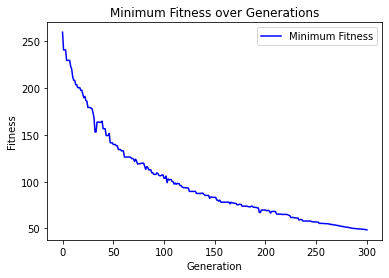

In [18]:
# Best individual EVER
print(f"Best individual is: {hof[0]}, {len(hof[0])} \nwith fitness: {hof[0].fitness}")

gen = logbook.select("gen")
fit_mins = logbook.select("min")

fig, ax = plt.subplots()
line = ax.plot(gen, fit_mins, "b-", label="Minimum Fitness")
ax.set_xlabel("Generation")
ax.set_ylabel("Fitness")
ax.set_title("Minimum Fitness over Generations")
ax.legend()
plt.show()

In [16]:
array =  [89, 16, 81, 63, 20, 54, 32, 76, 27, 95, 51, 1, 15, 7, 35, 69, 23, 49, 3, 87, 21, 55, 12, 50, 38, 31, 77, 96, 98, 70, 73, 90, 30, 34, 36, 41, 37, 93, 92, 82, 85, 94, 4, 39, 72, 53, 57, 8, 56, 44, 11, 59, 29, 0, 86, 52, 74, 91, 61, 79, 22, 68, 43, 84, 80, 17, 26, 78, 75, 71, 88, 33, 42, 6, 45, 48, 18, 60, 24, 97, 67, 2, 47, 25, 10, 46, 28, 64, 9, 14, 83, 65, 19, 40, 62, 58, 13, 5, 66]

# verify is the array have repeated values
# True if the array have NOT repeated values, False if the array have repeated values
print(len(array) == len(set(array)))



True


In [ ]:

gen = logbook.select("gen")
fit_mins = logbook.select("min")

fig, ax = plt.subplots()
line = ax.plot(gen, fit_mins, "b-", label="Minimum Fitness")
ax.set_xlabel("Generation")
ax.set_ylabel("Fitness")
ax.set_title("Minimum Fitness over Generations")
ax.legend()
plt.show()

# Best on so far

In [ ]:
best_individual = hof[0]
print(f"Best individual is: {best_individual} \nwith total distance: {best_individual.fitness.values[0]}")
print("Distances between the points: ")
for i in range(len(best_individual) - 1):
    print(f"Distance from {best_individual[i]} to {best_individual[i+1]}: {best_individual.distances[i]}")


# Show example results for differently sized inputs (including run time).

# What is the length of the shortest route that runs through all 100 Ecopoints?


# Optional Report for Bonus points
By submitting a pdf containing the code you developed and the results you obtained in
section 5, you will get a 1 val bonus on Project 3 (available soon). The optional report
should be submitted together with Project 3. 